# GEE - Get Training Data

Step-by-step guide to getting training data from GEE.

In [1]:

import datetime
import os
import sys
import time
from typing import Tuple

import ee
import pandas as pd
import rasterio
from shapely import affinity, geometry
from tqdm import tqdm

sys.path.append(os.path.join("..", "..", "code"))
from google_helper_functions import (
    authenticate_gee, connect_to_service_account_gdrive, download_files_from_gdrive
)
from identify_watersheds import map_elevation_point, save_gee_elv_to_drive, WatershedIdentifier


DATA_DIR = os.path.join("..", "..", "data")
gages = pd.read_csv(os.path.join(DATA_DIR, "target_gages.csv"), encoding="utf-8")

## Authenticate with GEE

Authenticate with GEE using stored credentials for a [service account](https://developers.google.com/earth-engine/guides/service_account).

In [2]:
# Authenticate with service account:
service_acct = "capstone-gee-account@snow-capstone.iam.gserviceaccount.com"
keys = os.path.join(os.path.expanduser("~"), "snow-capstone-4a3c9603fcf0.json")
credentials = authenticate_gee(service_acct, keys)

# Alternative manual authentication method:
# ee.Authenticate()
# ee.Initialize()

## Define geographic target area

Using the watershed bounding box identified in [this notebook](../watersheds/Streamgage%2011266500%20Watershed.ipynb) as our target area:

In [3]:
bounding_box = (-119.67499945485724, 37.69744157196207, -119.66583663895922, 37.71684518209905)
left, bottom, right, top = bounding_box

In [4]:
def get_polygon(left: float, bottom: float, right: float, top: float, buffer_percent: float = 0.05):
    coords = [
        [left, top],
        [right, top],
        [right, bottom],
        [left, bottom],
        [left, top],
    ]
    shape = geometry.Polygon(coords)
    if buffer_percent > 0:
        shape = geometry.Polygon(affinity.scale(shape, xfact=(1. + buffer_percent), yfact=(1. + buffer_percent)).exterior.coords)
    return shape

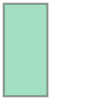

In [5]:
polygon_no_buffer = get_polygon(left, bottom, right, top, buffer_percent=0.0)
polygon_no_buffer

In [6]:
list(polygon_no_buffer.boundary.coords)

[(-119.67499945485724, 37.71684518209905),
 (-119.66583663895922, 37.71684518209905),
 (-119.66583663895922, 37.69744157196207),
 (-119.67499945485724, 37.69744157196207),
 (-119.67499945485724, 37.71684518209905)]

In [7]:
polygon_buffer = get_polygon(left, bottom, right, top, buffer_percent=0.05)
list(polygon_buffer.boundary.coords)

[(-119.6752285252547, 37.71733027235248),
 (-119.66560756856177, 37.71733027235248),
 (-119.66560756856177, 37.696956481708646),
 (-119.6752285252547, 37.696956481708646),
 (-119.6752285252547, 37.71733027235248)]

## Get the GEE image collection for the target satellite bands

Make the request to GEE for the target satellite and band for the bounding box region, and specified date range.

(With help from [this SO post](https://stackoverflow.com/questions/67289225/download-image-from-google-earth-engine-imagecollection-to-drive)).

In [8]:
DATE_FORMAT = "%Y_%m_%d"


def get_ee_img_collection(sat_name: str, polygon: geometry.Polygon,
                          date_from: str, date_to: str):
    """Get ee.ImageCollection for a satellite.
    
    """
    gee_polygon = ee.Geometry.Polygon(list(polygon.boundary.coords))
    date_from, date_to = datetime.datetime.strptime(date_from, DATE_FORMAT), datetime.datetime.strptime(date_to, DATE_FORMAT)
    return ee.ImageCollection(sat_name).filterDate(date_from, date_to).filterBounds(gee_polygon)

In [9]:
# Get the image collection for a single year:
ic = get_ee_img_collection("MODIS/006/MOD16A2", polygon_buffer, "2018_01_01", "2018_12_31")

In [10]:
# Get the image collection metadata:
info = ic.getInfo()
sat_id = info["id"]
sat_id

'MODIS/006/MOD16A2'

In [11]:
# Number of images to download from the image collection:
num_img = ic.size().getInfo()
num_img

46

In [12]:
# Convert to a list of images:
img_list = ic.toList(num_img)
img_list

In [13]:
# Select the first image:
img = ee.Image(img_list.get(0))
img

In [14]:
# Date of the image:
img_date = img.date().getInfo()
img_date

{'type': 'Date', 'value': 1514764800000}

In [15]:
# As a human readable date:
hdate = datetime.datetime.utcfromtimestamp(img_date["value"] / 1000).strftime(DATE_FORMAT)
hdate

'2018_01_01'

In [16]:
# Bands available in the image collection:
ic_bands = img.bandNames().getInfo()
ic_bands

['ET', 'LE', 'PET', 'PLE', 'ET_QC']

In [17]:
# Select a band:
band = "ET"
band_et = img.select(band)
band_et

In [18]:
# Save the band image to drive:
gee_polygon = ee.Geometry.Polygon(list(polygon_buffer.boundary.coords))

# Reproject:
crs = "epsg:4326"
scale = 500
reprojection = band_et.reproject(crs=crs, scale=scale)

filename = f"{crs} - {scale} - {sat_id}_{band}_{hdate}".replace("/", "_")

task = ee.batch.Export.image.toDrive(
    reprojection.toFloat(),
    description = f"Example image download {crs} - {scale} - {band} - {hdate}",
    folder = "test",
    fileNamePrefix = filename,
    region = gee_polygon,
    fileFormat = "GeoTIFF",
    maxPixels = 1e10
)
task.start()
while task.status()["state"] != "COMPLETED":
    time.sleep(1)
print(task.status())

{'state': 'COMPLETED', 'description': 'Example image download epsg:4326 - 500 - ET - 2018_01_01', 'creation_timestamp_ms': 1664851490080, 'update_timestamp_ms': 1664851513354, 'start_timestamp_ms': 1664851507450, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1HmjhMj3AZTAaBcA529X3_fjHLVqDY52T'], 'attempt': 1, 'batch_eecu_usage_seconds': 0.037943318486213684, 'id': 'RLKNY6LPXE2FN2TV2TNAX5WU', 'name': 'projects/earthengine-legacy/operations/RLKNY6LPXE2FN2TV2TNAX5WU'}


In [19]:
# Download the file from G:Drive to a local copy:
drive = connect_to_service_account_gdrive(keys)
save_to = os.path.join(DATA_DIR, "test")
local_files = download_files_from_gdrive(drive, filename, save_to, download_all=True)
tif_fp = local_files[0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


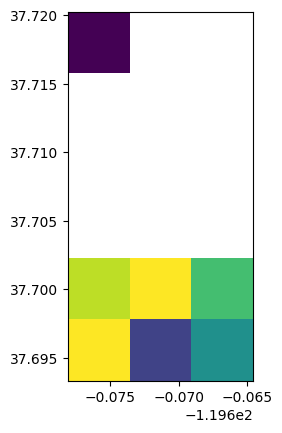

<AxesSubplot:>

In [20]:
# Inspect the raw TIF file:
from rasterio.plot import show

tif_data = rasterio.open(tif_fp)
show(tif_data, with_bounds=True)

## Function

Wrapping everything above into a single function to download multiple images.

In [37]:
import string

punctuation_mapping = {p: "_" for p in string.punctuation}


def remove_punctuation(s: str):
    return s.translate(str.maketrans(punctuation_mapping))


def export_image_collection_to_gdrive(
    bounding_box: Tuple[float],
    sat_name: str, 
    band: str,
    date_from: str, 
    date_to: str,
    buffer_percent: float = 0.05,
    crs: str = "epsg:4326",
    scale: float = 100
    ):
    
    # Define the region of interest:
    left, bottom, right, top = bounding_box
    polygon = get_polygon(left, bottom, right, top, buffer_percent=buffer_percent)
    
    # Get the GEE image collection:
    ic = get_ee_img_collection(sat_name=sat_name, polygon=polygon, date_from=date_from, date_to=date_to)
    
    # # Get the image collection metadata:
    # info = ic.getInfo()
    # sat_id = info["id"]
    
    # Number of images to download from the image collection:
    num_img = ic.size().getInfo()
    print(f"Satellite {sat_name}: {num_img:,.0f} images") 
    
    # Convert to a list of images:
    img_list = ic.toList(num_img)
    
    # Export the images one by one:
    all_tasks, filenames = list(), list()
    for i in range(num_img):
        
        # Select the image:
        img = ee.Image(img_list.get(i))
        
        # Date of the image:
        img_date = img.date().getInfo()
        hdate = datetime.datetime.utcfromtimestamp(img_date["value"] / 1000).strftime(DATE_FORMAT)
        print(f"> Task {str(i+1).zfill(7)} - {hdate}")
        
        # Select a band:
        img_band = img.select(band)
            
        # Get the GEE polygon shape
        gee_polygon = ee.Geometry.Polygon(list(polygon.boundary.coords))

        # Reproject:
        reprojection = img_band.reproject(crs=crs, scale=scale)
        
        # Export to G:Drive:
        sat_name_c, crs_c, band_c, hdate_c = remove_punctuation(sat_name), remove_punctuation(crs), remove_punctuation(band), remove_punctuation(hdate)
        filename = f"{crs_c}__{scale}__{sat_name_c}__{band_c}__{hdate_c}"
        task = ee.batch.Export.image.toDrive(
            reprojection.toFloat(),
            description = f"Image {filename}",
            folder = f"{sat_name_c}",
            fileNamePrefix = filename,
            region = gee_polygon,
            fileFormat = "GeoTIFF",
            maxPixels = 1e10
        )
        task.start()
        
        all_tasks.append(task)
        filenames.append(filename)
        
    return all_tasks, filenames

In [38]:
all_tasks, filenames = export_image_collection_to_gdrive(
    bounding_box = (-119.67499945485724, 37.69744157196207, -119.66583663895922, 37.71684518209905),
    sat_name = "MODIS/006/MOD16A2", 
    band = "ET",
    date_from = "2018_01_01", 
    date_to = "2018_01_31",
    buffer_percent = 0.05,
    crs = "epsg:4326",
    scale = 100
)

Satellite MODIS/006/MOD16A2: 4 images
> Exporting image 0000001 - 2018_01_01
> Exporting image 0000002 - 2018_01_09
> Exporting image 0000003 - 2018_01_17
> Exporting image 0000004 - 2018_01_25


In [43]:
task_df = pd.DataFrame([t.status() for t in all_tasks])
task_df["filename"] = filenames
task_df

,state,description,creation_timestamp_ms,update_timestamp_ms,start_timestamp_ms,task_type,destination_uris,attempt,batch_eecu_usage_seconds,id,name,filename
0,COMPLETED,Image epsg_4326__100__MODIS_006_MOD16A2__ET__2...,1664851781838,1664851802034,1664851796202,EXPORT_IMAGE,[https://drive.google.com/#folders/1q10edbzAew...,1,0.026629,PIK5TXI5HFMF72I5CTRKTX6D,projects/earthengine-legacy/operations/PIK5TXI...,epsg_4326__100__MODIS_006_MOD16A2__ET__2018_01_01
1,COMPLETED,Image epsg_4326__100__MODIS_006_MOD16A2__ET__2...,1664851782423,1664851804482,1664851796928,EXPORT_IMAGE,[https://drive.google.com/#folders/1q10edbzAew...,1,0.031945,U5FFZHUZWS6AB4PJFJIRCLCU,projects/earthengine-legacy/operations/U5FFZHU...,epsg_4326__100__MODIS_006_MOD16A2__ET__2018_01_09
2,COMPLETED,Image epsg_4326__100__MODIS_006_MOD16A2__ET__2...,1664851783016,1664851803970,1664851797196,EXPORT_IMAGE,[https://drive.google.com/#folders/1q10edbzAew...,1,0.047755,DCO33256RYR257FWY7UPCQV4,projects/earthengine-legacy/operations/DCO3325...,epsg_4326__100__MODIS_006_MOD16A2__ET__2018_01_17
3,COMPLETED,Image epsg_4326__100__MODIS_006_MOD16A2__ET__2...,1664851783681,1664851804209,1664851797964,EXPORT_IMAGE,[https://drive.google.com/#folders/1q10edbzAew...,1,0.049730,7PL32UH6WBCOREN5OK6LMKV2,projects/earthengine-legacy/operations/7PL32UH...,epsg_4326__100__MODIS_006_MOD16A2__ET__2018_01_25


In [44]:
while set(task_df["state"]) != {"COMPLETED"}:
    time.sleep(1)

In [45]:
# Strip out the datetime to get the file pattern to match on:
eg_file = filenames[0]
file_pat = "__".join(eg_file.split("__")[:-1])

In [46]:
# Get df of all matching files:
filelist = drive.ListFile().GetList()
file_df = pd.DataFrame(filelist)
matching_files = file_df[file_df["title"].str.contains(file_pat)]
matching_files

,kind,id,etag,selfLink,webContentLink,alternateLink,embedLink,iconLink,title,mimeType,...,editable,copyable,writersCanShare,shared,explicitlyTrashed,appDataContents,headRevisionId,imageMediaMetadata,spaces,thumbnailLink
0,drive#file,1RQvZl1pgCVIRsM7sefqSDE09mkfbe1nj,"""MTY2NDg1MTgwNDA0NQ""",https://www.googleapis.com/drive/v2/files/1RQv...,https://drive.google.com/uc?id=1RQvZl1pgCVIRsM...,https://drive.google.com/file/d/1RQvZl1pgCVIRs...,https://drive.google.com/file/d/1RQvZl1pgCVIRs...,https://drive-thirdparty.googleusercontent.com...,epsg_4326__100__MODIS_006_MOD16A2__ET__2018_01...,image/tiff,...,True,True,True,False,False,False,0By30p8yLomMtRTQ4SFhsd20rMnIvaFA3TmhieVNEdHZja...,"{'width': 0, 'height': 0}",[drive],NaN
1,drive#file,1CG5eTlKX4hNBw4KubljIcJgkgiCiWlR3,"""MTY2NDg1MTgwMzc3MQ""",https://www.googleapis.com/drive/v2/files/1CG5...,https://drive.google.com/uc?id=1CG5eTlKX4hNBw4...,https://drive.google.com/file/d/1CG5eTlKX4hNBw...,https://drive.google.com/file/d/1CG5eTlKX4hNBw...,https://drive-thirdparty.googleusercontent.com...,epsg_4326__100__MODIS_006_MOD16A2__ET__2018_01...,image/tiff,...,True,True,True,False,False,False,0By30p8yLomMtRDJvQ2NENEdibjA2SUtLT3Rxb1cyRUQ2d...,"{'width': 0, 'height': 0}",[drive],NaN
2,drive#file,18pObC1QDlCIoQljrZ3K2jbnltO_7iMlZ,"""MTY2NDg1MTgwMzQ5MA""",https://www.googleapis.com/drive/v2/files/18pO...,https://drive.google.com/uc?id=18pObC1QDlCIoQl...,https://drive.google.com/file/d/18pObC1QDlCIoQ...,https://drive.google.com/file/d/18pObC1QDlCIoQ...,https://drive-thirdparty.googleusercontent.com...,epsg_4326__100__MODIS_006_MOD16A2__ET__2018_01...,image/tiff,...,True,True,True,False,False,False,0By30p8yLomMtODVEaXl3MjZWU2NSSzNyOEpxV1JrVlEzQ...,"{'width': 0, 'height': 0}",[drive],NaN
3,drive#file,1CiVFa7zdcWxGBz6unJV2ekz2DP_1cm_T,"""MTY2NDg1MTgwMTQ4NQ""",https://www.googleapis.com/drive/v2/files/1CiV...,https://drive.google.com/uc?id=1CiVFa7zdcWxGBz...,https://drive.google.com/file/d/1CiVFa7zdcWxGB...,https://drive.google.com/file/d/1CiVFa7zdcWxGB...,https://drive-thirdparty.googleusercontent.com...,epsg_4326__100__MODIS_006_MOD16A2__ET__2018_01...,image/tiff,...,True,True,True,False,False,False,0By30p8yLomMtV2RudHF4eURIRnp3bi8vMGNGekJWeWVrc...,"{'width': 0, 'height': 0}",[drive],NaN


In [47]:
# Download the files from GDrive:
downloaded = list()
for ix in tqdm(matching_files.index):
    row = matching_files.loc[ix]
    target = os.path.join(save_to, row["title"])
    f = filelist[ix]
    f.GetContentFile(target)
    downloaded.append(target)
downloaded

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.55it/s]


['../../data/test/epsg_4326__100__MODIS_006_MOD16A2__ET__2018_01_09.tif',
 '../../data/test/epsg_4326__100__MODIS_006_MOD16A2__ET__2018_01_25.tif',
 '../../data/test/epsg_4326__100__MODIS_006_MOD16A2__ET__2018_01_17.tif',
 '../../data/test/epsg_4326__100__MODIS_006_MOD16A2__ET__2018_01_01.tif']

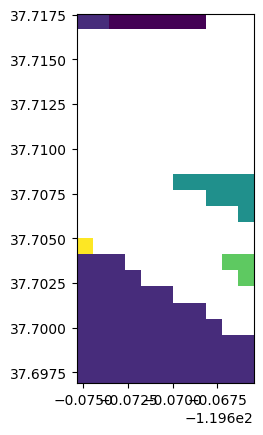

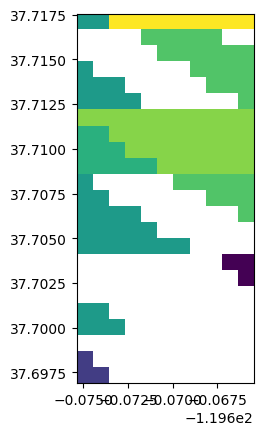

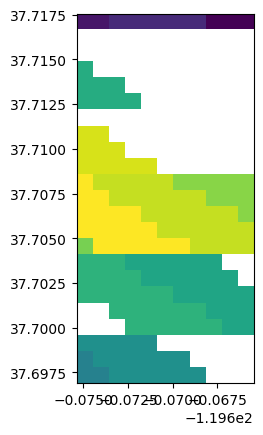

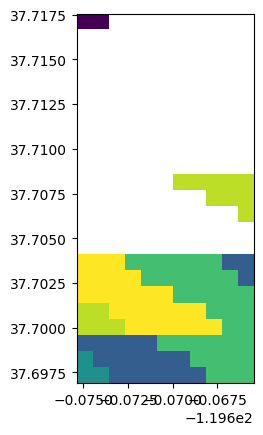

In [48]:
# Inspect the raw TIF files:
from rasterio.plot import show

for tif_fp in downloaded:
    tif_data = rasterio.open(tif_fp)
    show(tif_data, with_bounds=True)